In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import linear_kernel

In [33]:
# reference_article = 'https://towardsdatascience.com/how-i-used-machine-learning-to-classify-emails-and-turn-them-into-insights-efed37c1e66'
# reference_article2 = 'https://towardsdatascience.com/how-i-used-machine-learning-to-classify-emails-and-turn-them-into-insights-part-2-6a8f26477c86'

In [34]:
# df = pd.read_excel(r"C:\Users\Harsh Garg\Desktop\intract\Email Subject Line Extra got online.xlsx", index = False)
# preprocessing required

In [4]:
emails = pd.read_excel(r"C:\Users\Harsh Garg\Desktop\intract\Email Subject Line Scrapper.xlsx",None)

In [5]:
emails.keys()

dict_keys(['config', 'data', 'Saved Data', 'Sheet4'])

In [6]:
emails = emails.get('Saved Data')

In [7]:
emails.shape

(1541, 8)

In [8]:
emails = emails.drop(columns = 'Unnamed: 7')

emails = emails.drop_duplicates(subset = 'Message Id')
emails = emails.drop_duplicates(subset = 'Subject Line')

In [9]:
emails.shape

(1119, 7)

In [10]:
emails.head()

,Date,Message Id,From,Email,Subject Line,Concated Body,Email from
0,2021-10-01 19:26:52,17c3c24c23506d3c,Paytm Offers,noreply@paytmoffers.in,"Aey Raju, Salary Aa Gayi Rey Baba 🤓",Paytm par deals check kar to,NaN
1,2021-10-01 13:50:21,17c3af0a22235012,Swiggy Instamart,alerts@updates.swiggy.in,October's first grocery bill will be a short o...,Email Template \n[image: Get 3,NaN
2,2021-10-01 11:43:23,17c3a816c53f6b1c,Zomato,noreply@mailers.zomato.com,Guess who always makes you smile? 😃,Here are your hints - you lov,abhishek12318@gmail.com
3,2021-10-01 11:30:42,17c3a70d12cf6c44,BookMyShow Stream,no-reply@explore.bookmyshow.com,INCOMING:Max G.I.Joe Ninja action ft.Henry Gol...,[image: BOOKMYSHOW STREAM |,NaN
4,2021-10-01 06:34:20,17c396185aa93ea4,Flipkart,no-reply@ncb.flipkart.com,New AC/TV/Laptop on your mind?,NaN,NaN


In [11]:
emails = emails[['Email','Subject Line','Email from']]
emails['Email from'] = emails['Email from'].fillna('abhishek12318@gmail.com')

### Experimental - Start (TFIDF)

In [43]:
stopwords = ENGLISH_STOP_WORDS.union(['swiggy','zomato','aggarwal','harsh','garg','abhishek','2021','11','ve','ncr',
                                      'delhi','sep','october','india','anita','harshgarg297@gmail.com',
                                      'abhishek12318@gmail.com','000','10','100','12','13','14','143','16','19','20','2020',
                                      '2022','21','2192573831','24','25','250','2568642602','26th','30','360','3657963965',
                                      '420','499','50','500','60','75','80','90','99','999','abhishek12318', 'com', 
                                      'gmail', 'harshgarg297','ramji','kyc','ft','prathamesh','pathwardhan','singh','flipkart',
                                      'amazon','january','jan','feb','february','mar','march','apr','april','may','june','jun',
                                      'july','aug','august','sept','september','oct','nov','november','dec','december'])
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
# emails['Subject Line'] = emails['Subject Line'].apply(lambda x: lemmatizer.lemmatize(x))
emails['Subject Line'] = emails['Subject Line'].apply(lambda x: ps.stem(x))
vect = TfidfVectorizer(analyzer = 'word',stop_words=stopwords, max_df=0.50, min_df=2)
X = vect.fit_transform(emails['Subject Line'])

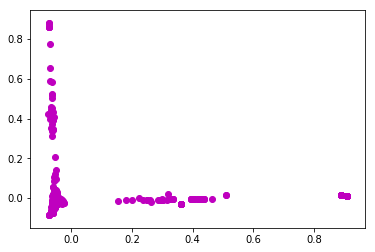

In [276]:
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

In [277]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [278]:
features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 10))

  features     score
0    short  0.744948
1  grocery  0.667122
2     yoga  0.000000
3    genie  0.000000
4     gear  0.000000
5      gas  0.000000
6   ganesh  0.000000
7     game  0.000000
8   future  0.000000
9    funny  0.000000


In [279]:
def top_mean_feats(X, features,
 grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [280]:
print(top_mean_feats(X, features, top_n=10))

  features     score
0    order  0.048556
1      new  0.015817
2      day  0.015544
3    today  0.011769
4  summary  0.010785
5     free  0.010671
6     make  0.010476
7     time  0.010120
8     just  0.008665
9      big  0.008474


# Elbow to find ideal cluster number

In [281]:
distortions = []
K = range(1,10)
for k in K:
    clf = KMeans(n_clusters=k, max_iter=100, init='k-means++', n_init=1)
    clf.fit(X)
    distortions.append(clf.inertia_)

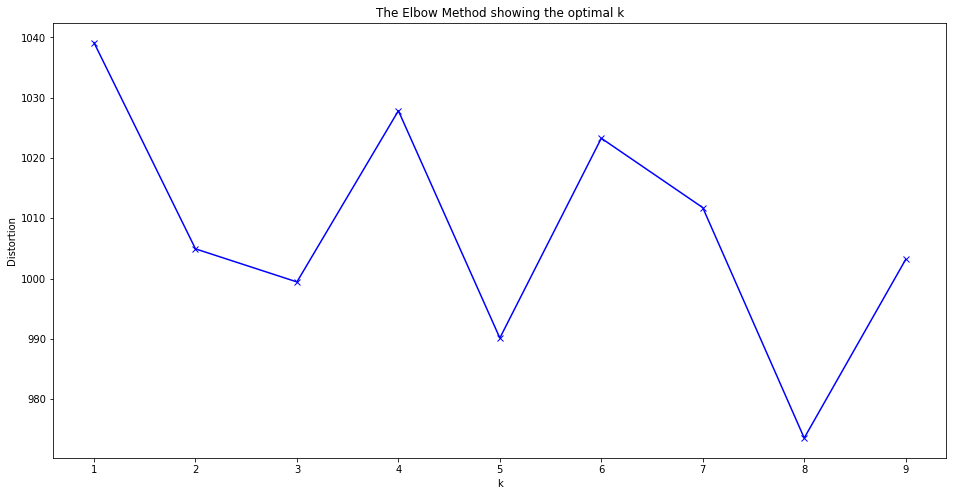

In [282]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [283]:
n_clusters = 2
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

In [284]:
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]

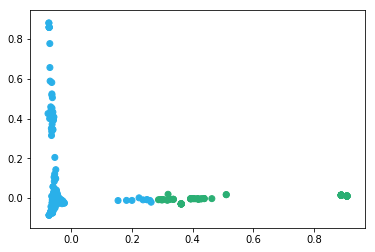

In [285]:
plt.scatter(coords[:, 0], coords[:, 1], c=colors)

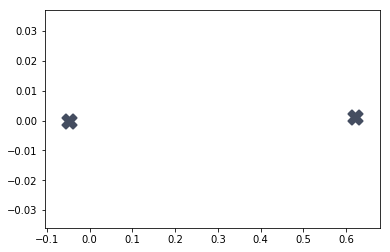

In [286]:
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
plt.show()

In [287]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

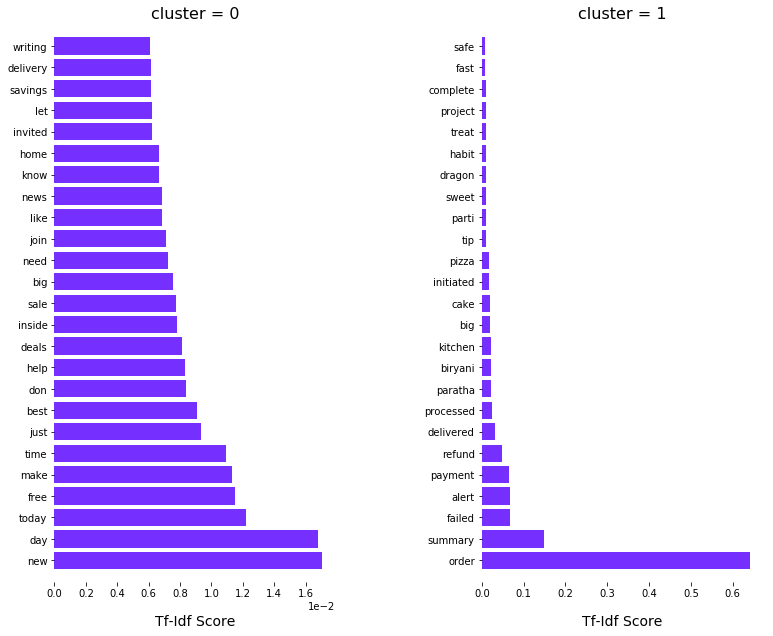

In [288]:
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))

# Cosine Similarity

#### Cos Sim of 1 email header against everything

In [271]:
cosine_sim = linear_kernel(X[0:1], X).flatten()
print(cosine_sim)

[1. 0. 0. ... 0. 0. 0.]


#### Cos Sim of query against everything to find relevant email headers

In [290]:
query = "pizza"

vec_query = vect.transform([query]) #vect is tfidvectorization class instance initiated with params

cosine_sim = linear_kernel(vec_query, X).flatten()
print(cosine_sim)

[0. 0. 0. ... 0. 0. 0.]


In [291]:
related_email_indices = cosine_sim.argsort()[:-10:-1]
print(related_email_indices)

[226 340 199 379 378 377 376 375 374]


In [296]:
# Print out the first result
first_email_index = related_email_indices[0]
print(emails['Subject Line'].as_matrix()[first_email_index])

your zomato order from nomad pizza - traveller seri


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


### Experimental - End

# Automated process to find email headers by a query using cosine similarity

In [297]:
def read_email_bodies():
    emails = pd.read_excel(r"C:\Users\Harsh Garg\Desktop\intract\Email Subject Line Scrapper.xlsx",'Saved Data')
    emails = emails.drop(columns = 'Unnamed: 7')
    emails = emails.drop_duplicates(subset = 'Message Id')
    emails = emails.drop_duplicates(subset = 'Subject Line')
    emails = emails[['Email','Subject Line','Email from']]
    emails['Email from'] = emails['Email from'].fillna('abhishek12318@gmail.com')
    
    return emails['Subject Line']

class EmailDataset: 
    def __init__(self):
        stopwords = ENGLISH_STOP_WORDS.union(['swiggy','zomato','aggarwal','harsh','garg','abhishek','2021','11','ve','ncr',
                                      'delhi','sep','october','india','anita','harshgarg297@gmail.com',
                                      'abhishek12318@gmail.com','000','10','100','12','13','14','143','16','19','20','2020',
                                      '2022','21','2192573831','24','25','250','2568642602','26th','30','360','3657963965',
                                      '420','499','50','500','60','75','80','90','99','999','abhishek12318', 'com', 
                                      'gmail', 'harshgarg297','ramji','kyc','ft','prathamesh','pathwardhan','singh','flipkart',
                                      'amazon','january','jan','feb','february','mar','march','apr','april','may','june','jun',
                                      'july','aug','august','sept','september','oct','nov','november','dec','december'])
        self.vec = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
        self.emails = read_email_bodies() 

        # train on the given email data.
        self.train()
  
    def train(self):
        self.vec_train = self.vec.fit_transform(self.emails)

    def query(self, keyword, limit):
        vec_keyword = self.vec.transform([keyword])
        cosine_sim = linear_kernel(vec_keyword, self.vec_train).flatten()
        related_email_indices = cosine_sim.argsort()[:-limit:-1]
        return related_email_indices

    def find_email_by_index(self, i):
        return self.emails.as_matrix()[i]

In [300]:
test_var = EmailDataset()

In [304]:
test_var.query('fast',10)

array([217, 456, 104, 381, 380, 379, 378, 377, 376], dtype=int64)

In [305]:
test_var.find_email_by_index(217)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


"Know someone who's on a fast? 🤔"

# Word2Vec

In [ ]:
'''https://stackabuse.com/implementing-word2vec-with-gensim-library-in-python/'''

In [14]:
import bs4 as bs
import urllib.request
import re
import nltk

In [132]:
# scrapped_data = urllib.request.urlopen('https://en.wikipedia.org/wiki/Emotions')
# article = scrapped_data.read()

# parsed_article = bs.BeautifulSoup(article,'lxml')

# paragraphs = parsed_article.find_all('p')

# article_text = ""

# for p in paragraphs:
#     article_text += p.text

'''In the script above, we first download the Wikipedia article using the urlopen method of the 
request class of the urllib library. We then read the article content and parse it using an object of the 
BeautifulSoup class. Wikipedia stores the text content of the article inside p tags. We use the find_all 
function of the BeautifulSoup object to fetch all the contents from the paragraph tags of the article'''

'In the script above, we first download the Wikipedia article using the urlopen method of the \nrequest class of the urllib library. We then read the article content and parse it using an object of the \nBeautifulSoup class. Wikipedia stores the text content of the article inside p tags. We use the find_all \nfunction of the BeautifulSoup object to fetch all the contents from the paragraph tags of the article'

In [200]:
emails = pd.read_excel(r"C:\Users\Harsh Garg\Desktop\intract\Email Subject Line Scrapper.xlsx",'Saved Data')

In [204]:
article_text = ''
for x in emails['Subject Line']:
    article_text = article_text + ' ' + x

In [225]:
# Cleaing the text
processed_article = article_text.lower()
processed_article = re.sub('[^a-zA-Z]', ' ', processed_article )
processed_article = re.sub(r'\s+', ' ', processed_article)

# Preparing the dataset
all_sentences = nltk.sent_tokenize(processed_article)

all_words = [nltk.word_tokenize(sent) for sent in all_sentences]

# Removing Stop Words
# from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

stopwords = ENGLISH_STOP_WORDS.union(['swiggy','zomato','aggarwal','harsh','garg','abhishek','2021','11','ve','ncr',
                                      'delhi','sep','october','india','anita','harshgarg297@gmail.com',
                                      'abhishek12318@gmail.com','000','10','100','12','13','14','143','16','19','20','2020',
                                      '2022','21','2192573831','24','25','250','2568642602','26th','30','360','3657963965',
                                      '420','499','50','500','60','75','80','90','99','999','abhishek12318', 'com', 
                                      'gmail', 'harshgarg297','ramji','kyc','ft','prathamesh','pathwardhan','singh','flipkart',
                                      'amazon','january','jan','feb','february','mar','march','apr','april','may','june','jun',
                                      'july','aug','august','sept','september','oct','nov','november','dec','december'])


for i in range(len(all_words)):
    all_words[i] = [w for w in all_words[i] if w not in stopwords]

'''In the script above, we convert all the text to lowercase and then remove all the digits, special characters, 
and extra spaces from the text. After preprocessing, we are only left with the words.

The Word2Vec model is trained on a collection of words. First, we need to convert our article into sentences. 
We use nltk.sent_tokenize utility to convert our article into sentences. To convert sentences into words, we use 
nltk.word_tokenize utility. As a last preprocessing step, we remove all the stop words from the text.

After the script completes its execution, the all_words object contains the list of all the words in the article. 
We will use this list to create our Word2Vec model with the Gensim library.'''

'In the script above, we convert all the text to lowercase and then remove all the digits, special characters, \nand extra spaces from the text. After preprocessing, we are only left with the words.\n\nThe Word2Vec model is trained on a collection of words. First, we need to convert our article into sentences. \nWe use nltk.sent_tokenize utility to convert our article into sentences. To convert sentences into words, we use \nnltk.word_tokenize utility. As a last preprocessing step, we remove all the stop words from the text.\n\nAfter the script completes its execution, the all_words object contains the list of all the words in the article. \nWe will use this list to create our Word2Vec model with the Gensim library.'

In [226]:
from gensim.models import Word2Vec

word2vec = Word2Vec(all_words, min_count=2, hs = 1, negative = 0) #min_count controls words to be included in vocabulary based on minimum frequency

vocabulary = word2vec.wv.vocab
# print(vocabulary)

'''When the above script is executed, you will see a list of all the unique words occurring at least twice'''

'When the above script is executed, you will see a list of all the unique words occurring at least twice'

In [227]:
v1 = word2vec.wv['hello']
'''The vector v1 contains the vector representation for the word "artificial". By default, a hundred dimensional vector is 
created by Gensim Word2Vec.
Vectors generated through Word2Vec are not affected by the size of the vocabulary.'''

'''https://radimrehurek.com/gensim/models/word2vec.html'''

'https://radimrehurek.com/gensim/models/word2vec.html'

#### Finding Similar Words (an example)

In [228]:
sim_words = word2vec.wv.most_similar('hello',topn=2)

In [229]:
sim_words

[('days', 0.8252060413360596), ('s', 0.8213356733322144)]

#### PCA and Visualisation

In [230]:
'''https://towardsdatascience.com/visualization-of-word-embedding-vectors-using-gensim-and-pca-8f592a5d3354'''

'https://towardsdatascience.com/visualization-of-word-embedding-vectors-using-gensim-and-pca-8f592a5d3354'

In [231]:
X=word2vec[word2vec.wv.vocab]
df=pd.DataFrame(X)
df.index = list(word2vec.wv.vocab)
df.shape
df.head()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
mega,0.008751,-0.002894,-0.001563,0.006226,0.001202,0.000360,-0.002713,0.006981,-0.006270,-0.001551,...,-0.000050,-0.000027,-0.002755,-0.001558,0.003663,0.001773,0.001560,-0.002382,-0.002060,-0.003448
chopsticks,0.001723,0.003764,-0.000611,-0.005215,-0.000166,0.001023,-0.002564,-0.001762,-0.001807,-0.000882,...,0.002901,0.004968,0.000239,-0.002780,0.002472,-0.003272,-0.000027,-0.002666,0.001137,-0.001222
twitter,0.003092,-0.004378,0.003737,-0.003834,0.003650,0.000724,-0.001833,0.000498,0.002683,-0.001407,...,0.001794,-0.000785,-0.000346,0.003382,-0.003420,-0.000565,-0.004755,0.004779,-0.001730,-0.000496
path,-0.002140,-0.003088,-0.002949,0.004497,0.004138,0.001866,0.000825,-0.002988,-0.003284,-0.002138,...,0.003904,0.000740,0.003078,0.002206,-0.001970,0.001247,-0.002901,-0.000935,0.002695,-0.001013
sustainable,0.002435,-0.003588,0.003799,0.003741,0.004871,0.005033,-0.000932,-0.001567,0.005329,0.000434,...,0.003479,-0.002486,0.000210,-0.006340,-0.001351,0.004957,-0.007500,0.004090,0.006729,-0.000914


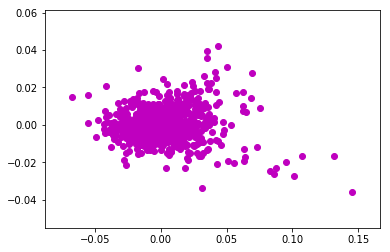

In [232]:
X_dense = df.copy()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

In [233]:
n_clusters = 2
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(df)

In [234]:
labels.shape, df.shape

((1103,), (1103, 100))

In [235]:
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]

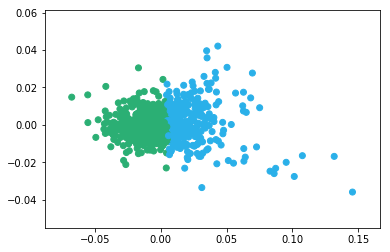

In [236]:
plt.scatter(coords[:,0],coords[:,1], c=colors)

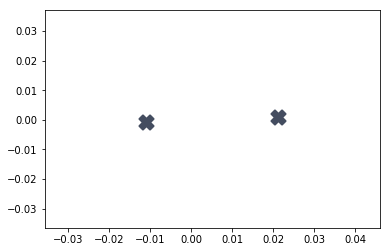

In [237]:
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
plt.show()

In [238]:
# squared distance to cluster center
X_dist = clf.transform(df)**2

# do something useful...
import pandas as pd
df_dist = pd.DataFrame(X_dist.sum(axis=1), columns=['sqdist'])
df_dist['label'] = clf.labels_

df_dist.head()

,sqdist,label
0,0.002333,0
1,0.002572,1
2,0.002338,1
3,0.002106,1
4,0.003717,1


In [239]:
df_analysis = pd.DataFrame()
df_analysis['Vocab'] = df.index
df_analysis['Dist'] = df_dist['sqdist']
df_analysis['Cluster'] = df_dist['label']
df_analysis['Inverse Dist'] = 1/df_analysis['Dist'] #To make it easier to rank the points for the clusters

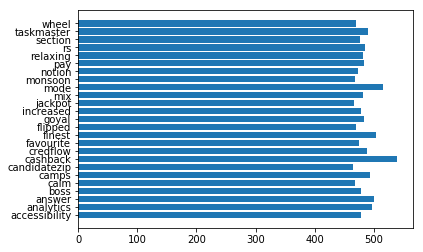

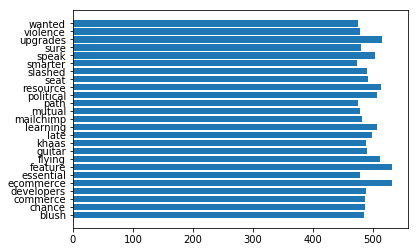

(None, None)

In [240]:
def plot_bar_closest(cluster_num, top_n, df):
    df = df[df['Cluster']==cluster_num]
    df = df.sort_values(by = 'Inverse Dist', ascending = False).iloc[:25]
    
    plt.barh(df['Vocab'], df['Inverse Dist'])
    plt.show()
plot_bar_closest(0,10,df_analysis), plot_bar_closest(1,10,df_analysis), 